In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel

from concurrent.futures import ThreadPoolExecutor, as_completed

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


/Users/aryasalian/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/aryasalian/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Fitting a model on "df.csv"

### Feature engineering and pre-processing

In [2]:
def feature_processing(data):
    # Making datetime objects
    data.date1 = pd.to_datetime(data.date1)
    data.birthdate = pd.to_datetime(data.birthdate)
    data.date2 = pd.to_datetime(data.date2)

    # Using age as of race date as an input feature
    data['age2'] = (data['date2']-data['birthdate']).dt.days
    data['season2'] = data['date2'].dt.month.apply(assign_season)

# Using season during race as an input feature
def assign_season(month):
    if month in [12, 1, 2]:
        return 0        # Winter
    elif month in [3, 4, 5]:
        return 1        # Spring
    elif month in [6, 7, 8]:
        return 2        # Summer
    else:
        return 3        # Fall

data = pd.read_csv("df.csv")
feature_processing(data)

# Stadium turned into categorical variable
label_encoder = LabelEncoder()
data['stadium_labels'] = label_encoder.fit_transform(data['stadium'])

def stadium_labeller(data):
    data['stadium_labels'] = label_encoder.transform(data.stadium)

### Converting race comments to embeddings using an altered BERT and multi-threading to hasten the processing
This can still take about 20 to 21 mins

In [3]:
# Global variables for model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModel.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Worker function for processing a batch of sentences
def get_batch_embeddings(sentences, batch_size=10):
    try:
        global tokenizer, model
        embeddings = []
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            tokens = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
            with torch.no_grad():
                outputs = model(**tokens)
            
            # Extract embeddings for each [CLS] token
            batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
            embeddings.extend(batch_embeddings)
        return embeddings
    except Exception as e:
        raise e


# Multithreading function
def get_embeddings_multithreading(sentences, chunk_size=100, batch_size=10, num_threads=2):

    # Split sentences into chunks
    chunks = [sentences[i:i + chunk_size] for i in range(0, len(sentences), chunk_size)]

    with tqdm(total=len(chunks), desc="Processing Chunks", unit="chunk") as pbar:
        # Process each chunk in parallel
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = {executor.submit(get_batch_embeddings, chunk, batch_size): idx for idx, chunk in enumerate(chunks)}
            results = [None] * len(chunks)
            for future in as_completed(futures):
                idx = futures[future]  # Get the index corresponding to the completed chunk
                try:
                    result = future.result()  # Retrieve the result of the completed chunk
                    results[idx] = result  # Store the result at the correct index
                    pbar.update(1)
                except Exception as e:
                    print(f"Chunk at index {idx} generated an exception: {e}")
                
    # Flatten the list of results
    embeddings = np.vstack(results)
    return embeddings

if __name__ == "__main__":
    data['comment1'] = data['comment1'].astype(str)
    sentences = data['comment1'].tolist()
    embeddings = get_embeddings_multithreading(sentences=sentences, chunk_size=500, batch_size=125, num_threads=10)
    embeddings_2dlist = embeddings.tolist()
    data['comment_embd'] = embeddings_2dlist

data.head()

Processing Chunks: 100%|██████████| 1067/1067 [18:37<00:00,  1.05s/chunk]


,stadium,birthdate,date1,time1,distance1,trap1,comment1,date2,distance2,trap2,time2,age2,season2,stadium_labels,comment_embd
0,Central Park,2018-12-01,2020-12-07,17.13,265,5,"slow away, middle to wide",2020-12-15,265,6,17.09,745,0,0,"[-0.6948814392089844, 0.05589760094881058, 0.1..."
1,Central Park,2018-12-01,2020-12-15,17.09,265,6,"wide, led half",2020-12-22,265,6,16.81,752,0,0,"[-0.7814004421234131, -0.37166905403137207, 0...."
2,Central Park,2018-12-01,2020-12-22,16.81,265,6,"wide, missed trouble and led first",2021-01-12,265,6,17.32,773,0,0,"[0.13132473826408386, -0.14902500808238983, 0...."
3,Central Park,2018-12-01,2021-01-12,17.32,265,6,"badly crowded half, badly baulked second",2021-01-19,265,6,17.10,780,0,0,"[-0.7448383569717407, 0.5653496384620667, -0.0..."
4,Central Park,2018-12-01,2021-01-19,17.10,265,6,"wide, challenged run in",2021-01-27,265,6,16.84,788,0,0,"[0.052009668201208115, -0.4212234318256378, 0...."


### So the features are:
* Age at time of race
* Embeddings of the comment
* Stadium of race
* Season of the year during race
* Previous race time
* Distance of the race
* Trap/Starting Position of the hound

### Splitting our data into test and train for our model
Unpacking may take about 7 to 8 mins

In [4]:
X = data.drop(columns=['time2'])
Y = data['time2']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Continuous features to be normalized
continuous_features = ['time1', 'distance1', 'distance2', 'trap2', 'age2']
scaler = StandardScaler()
X_train[continuous_features] = scaler.fit_transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

# Combining all features into a tensor
def prepare_features(df):
    continuous = df[continuous_features].values
    embeddings = np.stack(df['comment_embd'].values)  # Stack embeddings
    categorical = df[['stadium_labels', 'season2']].values
    return np.hstack([continuous, embeddings, categorical])

# Prepare tensors
X_train_tensor = torch.tensor(prepare_features(X_train), dtype=torch.float32)
print("X_train_tensor made...")
X_test_tensor = torch.tensor(prepare_features(X_test), dtype=torch.float32)
print("X_test_tensor made...")
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32).unsqueeze(1)
print("Y_train_tensor made...")
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32).unsqueeze(1)
print("Y_test_tensor made...")

X_train_tensor made...
X_test_tensor made...
Y_train_tensor made...
Y_test_tensor made...


### Training our RNN
Takes about 2-3 mins; early stoppage included if loss function hits a certain threshold

In [ ]:
# Define the RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)  # RNN Layer
        self.fc = nn.Linear(hidden_size, output_size)  # Fully Connected Layer

    def forward(self, x):
        # Passing data through RNN layer
        out, hidden = self.rnn(x)  # out: (batch_size, seq_length, hidden_size)
        
        # Passing last hidden state through the fully connected layer
        out = self.fc(out[:, -1, :])  # out: (batch_size, output_size)
        return out

# Hyperparameters
hidden_size = 64
num_layers = 1
output_size = 1  # Single output
input_size = X_train_tensor.shape[1]  # Number of features
batch_size = 32
learning_rate = 0.001
epochs = 20
mse_threshold = 0.21

# Creating DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor.unsqueeze(1), Y_train_tensor)  # Unsqueeze for seq_length=1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize Model, Loss, and Optimizer
rnnmodel = RNNModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
criterion = nn.MSELoss()    # Loss Function
optimizer = optim.Adam(rnnmodel.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(epochs):
    rnnmodel.train()  # Set model to training mode
    epoch_loss = 0.0

    for X_batch, Y_batch in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = rnnmodel(X_batch)

        # Compute the loss
        loss = criterion(outputs, Y_batch)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Accumulate loss for the epoch
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Avg. Loss: {avg_loss:.4f}")

    if avg_loss < mse_threshold:
        print(f"Stopping early: Loss {avg_loss} is below the threshold {mse_threshold}")
        break
        
torch.save(rnnmodel.state_dict(), "greyhound_rnn_model.pth")

Epoch 1/20, Loss: 115427.7232, Avg. Loss: 8.6586
Epoch 2/20, Loss: 3380.1676, Avg. Loss: 0.2536
Epoch 3/20, Loss: 3140.7014, Avg. Loss: 0.2356
Epoch 4/20, Loss: 3068.6054, Avg. Loss: 0.2302
Epoch 5/20, Loss: 3014.8821, Avg. Loss: 0.2262
Epoch 6/20, Loss: 2968.8817, Avg. Loss: 0.2227
Epoch 7/20, Loss: 2936.3773, Avg. Loss: 0.2203
Epoch 8/20, Loss: 2888.6931, Avg. Loss: 0.2167
Epoch 9/20, Loss: 2874.6051, Avg. Loss: 0.2156
Epoch 10/20, Loss: 2854.4378, Avg. Loss: 0.2141
Epoch 11/20, Loss: 2803.1237, Avg. Loss: 0.2103
Epoch 12/20, Loss: 2809.6309, Avg. Loss: 0.2108
Epoch 13/20, Loss: 2809.6756, Avg. Loss: 0.2108
Epoch 14/20, Loss: 2785.4478, Avg. Loss: 0.2089
Epoch 15/20, Loss: 2774.6651, Avg. Loss: 0.2081
Epoch 16/20, Loss: 2803.6519, Avg. Loss: 0.2103
Epoch 17/20, Loss: 2756.4858, Avg. Loss: 0.2068
Epoch 18/20, Loss: 2753.1017, Avg. Loss: 0.2065
Epoch 19/20, Loss: 2717.7762, Avg. Loss: 0.2039
Epoch 20/20, Loss: 2779.9953, Avg. Loss: 0.2085


### Testing the model

R-squared Score: 0.9924


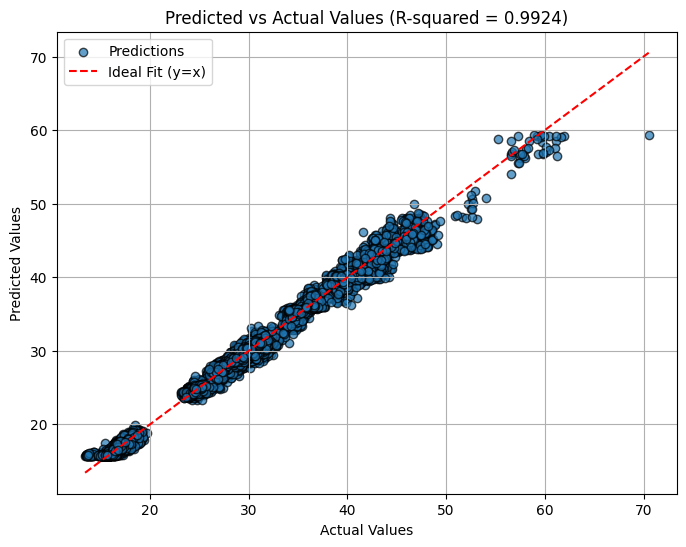

In [6]:
test_dataset = TensorDataset(X_test_tensor.unsqueeze(1), Y_test_tensor)  # Unsqueeze for seq_length=1
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Set model to evaluation mode
rnnmodel.eval()

# Collect predictions and true values
all_predictions = []
all_labels = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        predictions = rnnmodel(X_batch).squeeze()  # Shape: (batch_size,)
        all_predictions.extend(predictions.numpy())
        all_labels.extend(Y_batch.squeeze().numpy())

# Calculate R-squared
r2 = r2_score(all_labels, all_predictions)
print(f"R-squared Score: {r2:.4f}")

# Plot Predicted vs Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(all_labels, all_predictions, alpha=0.7, edgecolor='k', label="Predictions")
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label="Ideal Fit (y=x)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Predicted vs Actual Values (R-squared = {r2:.4f})")
plt.legend()
plt.grid()
plt.show()

# Predicting Values for "unseendf.csv"

In [ ]:
unseen_data = pd.read_csv("unseendf.csv")
feature_processing(unseen_data)
stadium_labeller(unseen_data)

if __name__ == "__main__":
    unseen_data['comment1'] = unseen_data['comment1'].astype(str)
    sentences = unseen_data['comment1'].tolist()
    embeddings = get_embeddings_multithreading(sentences=sentences, chunk_size=500, batch_size=125, num_threads=10)
    embeddings_2dlist = embeddings.tolist()
    unseen_data['comment_embd'] = embeddings_2dlist

unseen_data[continuous_features] = scaler.transform(unseen_data[continuous_features])

unseen_tensor = torch.tensor(prepare_features(unseen_data), dtype=torch.float32)
unseen_dataset = TensorDataset(unseen_tensor.unsqueeze(1))  # Unsqueeze for seq_length=1
test_loader = DataLoader(unseen_dataset, batch_size=1, shuffle=False)

unseen_preds = []

with torch.no_grad():
    for X_batch, in test_loader:    # the comma is needed to unpack the single element tuple
        predictions = rnnmodel(X_batch)
        unseen_preds.extend(predictions.numpy())

unseen_preds = [unseen_preds[x][0] for x in range(len(unseen_preds))]
unseen_data['predtime'] = unseen_preds
unseen_data.to_csv("~/Downloads/mypred.csv", index=False)

Processing Chunks: 100%|██████████| 1/1 [00:00<00:00, 17.65chunk/s]
